<a href="https://colab.research.google.com/github/RuTiO2le/WorldModel_Group06/blob/main/WorldModel_CLIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CLIPによる画像分類

In [ ]:
!pip install torchvision
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

import torch 
import clip 
from PIL import Image
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device) 

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-2visyrpc
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-2visyrpc


In [ ]:
!pip show torch

Name: torch
Version: 1.10.0+cu111
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: /usr/local/lib/python3.7/dist-packages
Requires: typing-extensions
Required-by: torchvision, torchtext, torchaudio, fastai, clip


In [ ]:
!nvidia-smi

Thu Mar 24 16:34:14 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    27W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

>## **CLIPのAPI**
* clip.tokenize(text: Union[str, List[str]], context_length=77).   
Returns a LongTensor containing tokenized sequences of given text input(s). This can be used as the input to the model
>
>
>* model.encode_image(image: Tensor).   
Given a batch of images, returns the image features encoded by the vision portion of the CLIP model.
>* model.encode_text(text: Tensor).   
Given a batch of text tokens, returns the text features encoded by the language portion of the CLIP model.
>* model(image: Tensor, text: Tensor).   
Given a batch of images and a batch of text tokens, returns two Tensors, containing the logit scores corresponding to each image and text input. The values are cosine similarities between the corresponding image and text features, times 100.

## 静止画の場合

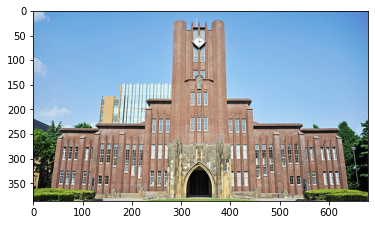

In [ ]:
IMG_PATH = "yasu.jpg"
# ラベル（自由に指定）
TEXT_LIST1 = ["building", "auditorium", "tower", "clock"]
TEXT_LIST2 = ["gothic", "baroque", "renaissance"]

plt.imshow(Image.open(IMG_PATH))

In [ ]:
for i, ls in enumerate([TEXT_LIST1, TEXT_LIST2]):
    # 公式では"a photo of"がついているが、なくても変わらない模様
    # for el in ls:
    #     el = "a photo of " + el

    # 画像の読み込み、テキストの用意 
    image_input = preprocess(Image.open(IMG_PATH)).unsqueeze(0).to(device) 
    text_input = clip.tokenize(ls).to(device) 

    with torch.no_grad():
        # 特徴ベクトルを抽出
        image_features = model.encode_image(image_input) 
        text_features = model.encode_text(text_input) 
        
        # 類似度の推論
        logits_per_image, logits_per_text = model(image_input, text_input)
        probs = logits_per_image.softmax(dim=-1).cpu().numpy() 

    print(f'\nLIST{i+1}')
    # 画像に対する上位2つのラベル
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    values, indices = similarity[0].topk(2)
    print("Top predictions:")
    for value, index in zip(values, indices):
        print(f"  {ls[index]}: {100 * value.item():.2f}%")
    
    # 類似度
    for i in range(len(ls)): 
        rate = probs[0][i]
        # print(f'{ls[i][:11]: <11s}---{rate: .2%}')
        print(f'{ls[i]: <11s}---{rate: .2%}')
    if i!=1: print()


LIST1
Top predictions:
  building: 66.60%
  tower: 20.00%
building   --- 66.60%
auditorium --- 9.75%
tower      --- 20.00%
clock      --- 3.64%


LIST2
Top predictions:
  gothic: 58.84%
  renaissance: 26.51%
gothic     --- 58.84%
baroque    --- 14.65%
renaissance--- 26.51%



## 動画の場合

In [ ]:
import cv2
from IPython.display import HTML
from base64 import b64encode

def save_all_frames(video_path, dir_path, basename, step, ext='jpg'):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        return

    os.makedirs(dir_path, exist_ok=True)
    base_path = os.path.join(dir_path, basename)

    n_frame = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    digit = len(str(n_frame))
    last_frame = n_frame - n_frame%step
    
    for i in range(0, n_frame+1, step):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if ret:
            cv2.imwrite(f'{base_path}_{str(i).zfill(digit)}.{ext}', frame)
    return last_frame

In [ ]:
video_path = "gs.mp4"
dir_path = "data/temp"
basename = "sample_video_img"
step = 10

# フレーム毎に保存
last_frame = save_all_frames(video_path, dir_path, basename, step)
last_frame

670

In [ ]:
# 動画の表示
mp4 = open('gs.mp4', 'rb').read()
data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()
HTML(f"""
<video width="25%" height="25%" controls>
      <source src="{data_url}" type="video/mp4">
</video>""")

※ 手元にあった手頃な動画が、以前チューリングパターンを生成したときの画面収録だけだったので、例としてはあまり適切ではないですが、コードは問題なく使えるということで...

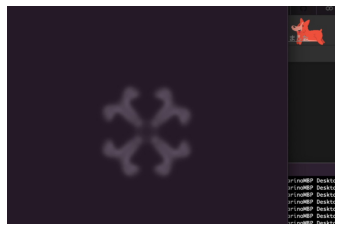

In [ ]:
# あるフレームの図示
IMG_PATH = "data/temp/sample_video_img_280.jpg"
plt.axis("off")
plt.imshow(Image.open(IMG_PATH))

In [ ]:
base = dir_path + '/' + basename
labels = ["flower", "dog"] # CLIPの学習アルゴリズム上、本当はテキストの方が良い
count = max(map(len, labels))
text_input = clip.tokenize(labels).to(device)
rates = []

for i in range(0, last_frame, step):
    IMG_PATH = f'{base}_{str(i).zfill(3)}.jpg'
    image_input = preprocess(Image.open(IMG_PATH)).unsqueeze(0).to(device) 

    with torch.no_grad():
        logits_per_image, logits_per_text = model(image_input, text_input)
        probs = logits_per_image.softmax(dim=-1).cpu().numpy() 

    print(f'frame {i: 3d}:')
    for i in range(len(labels)): 
        rate = probs[0][i]
        rates.append(rate)
        print(f'  {labels[i]: <{count+1}s}---{rate: .2%}')
    if i!=last_frame: print()

frame   0:
  flower     --- 58.50%
  dog        --- 41.48%

frame  10:
  flower     --- 62.60%
  dog        --- 37.38%

frame  20:
  flower     --- 60.40%
  dog        --- 39.60%

frame  30:
  flower     --- 57.37%
  dog        --- 42.63%

frame  40:
  flower     --- 62.26%
  dog        --- 37.74%

frame  50:
  flower     --- 57.37%
  dog        --- 42.63%

frame  60:
  flower     --- 53.12%
  dog        --- 46.88%

frame  70:
  flower     --- 49.61%
  dog        --- 50.39%

frame  80:
  flower     --- 46.48%
  dog        --- 53.52%

frame  90:
  flower     --- 47.27%
  dog        --- 52.73%

frame  100:
  flower     --- 46.88%
  dog        --- 53.12%

frame  110:
  flower     --- 47.27%
  dog        --- 52.73%

frame  120:
  flower     --- 43.77%
  dog        --- 56.20%

frame  130:
  flower     --- 47.66%
  dog        --- 52.34%

frame  140:
  flower     --- 61.13%
  dog        --- 38.87%

frame  150:
  flower     --- 63.33%
  dog        --- 36.67%

frame  160:
  flower     --- 64.06

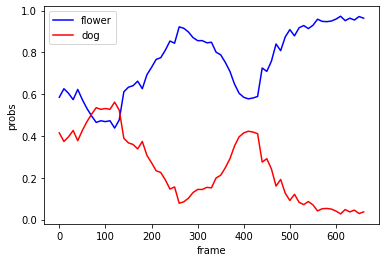

In [ ]:
plt.xlabel("frame")
plt.ylabel("probs")
plt.plot(range(0, last_frame, step), rates[::len(labels)],  label="flower", color="b")
plt.plot(range(0, last_frame, step), rates[1::len(labels)], label="dog",    color="r")
plt.legend()

右上にコーギーが映るタイミングでdogが上がると思ったら、そうでもありませんでした。

flowerが単調増加でないのも意外ですが、ラベルを増やせば近づきそうですね。(そもそも花ではないので、良いラベルを思いつきましたら是非教えてください笑)

## ロジスティック回帰（おまけ）

In [ ]:
import os

import numpy as np
from sklearn.linear_model import LogisticRegression
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR100
from tqdm import tqdm

# Load the dataset
root = os.path.expanduser("~/.cache")
train = CIFAR100(root, download=True, train=True, transform=preprocess)
test = CIFAR100(root, download=True, train=False, transform=preprocess)


def get_features(dataset):
    all_features = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(DataLoader(dataset, batch_size=100)):
            features = model.encode_image(images.to(device))

            all_features.append(features)
            all_labels.append(labels)

    return torch.cat(all_features).cpu().numpy(), torch.cat(all_labels).cpu().numpy()

# Calculate the image features
train_features, train_labels = get_features(train)
test_features, test_labels = get_features(test)

# Perform logistic regression
classifier = LogisticRegression(random_state=0, C=0.316, max_iter=1000, verbose=1)
classifier.fit(train_features, train_labels)

# Evaluate using the logistic regression classifier
predictions = classifier.predict(test_features)
accuracy = np.mean((test_labels == predictions).astype(np.float)) * 100.
print(f"Accuracy = {accuracy:.3f}")

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting /root/.cache/cifar-100-python.tar.gz to /root/.cache
Files already downloaded and verified


100%|██████████| 100/100 [00:20<00:00,  4.94it/s]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Accuracy = 80.020


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 13.1min finished
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/rel

In [ ]:
train_labels

array([19, 29,  0, ...,  3,  7, 73])

## modelについて
clip.loadの引数に用いるモデルには、以下が利用可能

In [ ]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14']